### Imports / load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from random import choice, randint
from revert.models import ConvNet
from torch.nn.functional import softmax

In [2]:
data = torch.load("../scripts-pcmri/pcmri_tensor.pt")
flows = data["flows"]
print("Shape:", len(flows), len(flows[0]), len(flows[0][0]))

Shape: 992 6 32


### Shift tests

In [3]:
def h_shift(signal, shift):
    return torch.roll(signal, shift)

In [4]:
test_sig = torch.Tensor(flows[0][0])
print(test_sig)
print(h_shift(test_sig, -5))

tensor([17251.7363, 16945.7520, 16221.2510, 14932.4463, 11781.4043,  8609.6182,
         8626.8408,  9816.2002,  9971.5557,  9845.8447,  8746.4258,  8243.5664,
         7928.6953,  7645.1997,  7038.2383,  6899.6030,  6676.5005,  6583.0698,
         6591.4360,  6541.9272,  6308.8916,  5956.5757,  5537.1719,  5136.6201,
         4786.1133,  5245.1606, 10141.9805, 16769.4805, 18287.0117, 16730.1875,
        16045.1064, 16873.2656])
tensor([ 8609.6182,  8626.8408,  9816.2002,  9971.5557,  9845.8447,  8746.4258,
         8243.5664,  7928.6953,  7645.1997,  7038.2383,  6899.6030,  6676.5005,
         6583.0698,  6591.4360,  6541.9272,  6308.8916,  5956.5757,  5537.1719,
         5136.6201,  4786.1133,  5245.1606, 10141.9805, 16769.4805, 18287.0117,
        16730.1875, 16045.1064, 16873.2656, 17251.7363, 16945.7520, 16221.2510,
        14932.4463, 11781.4043])


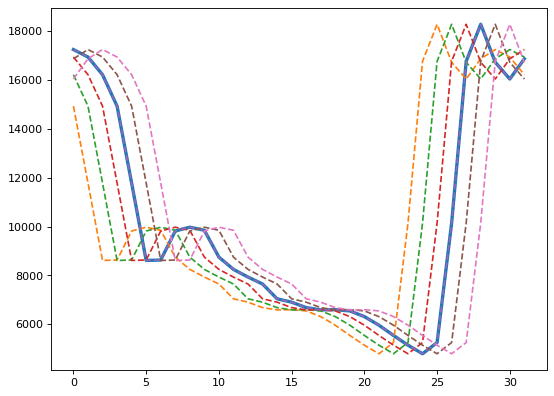

In [5]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(test_sig, linewidth=3)
for i in range(-3, 3):
    plt.plot(h_shift(test_sig, i), linestyle='--')

In [6]:
def rand_shift(channels):
    channel_nb = randint(0, 5)
    shift = choice([i for i in range(-5, 6) if i != 0])
    channels[channel_nb] = torch.roll(channels[channel_nb], shift)
    return channels, channel_nb

def plot_channels(channels):
    for channel in channels:
        plt.plot(channel)

def plot_side_by_side(channels1, channels2):
    plt.figure(figsize=(20, 6), dpi=70)
    plt.subplot(1, 2, 1)
    plot_channels(channels1)
    plt.subplot(1, 2, 2)
    plot_channels(channels2)

tensor([16602.7812, 16279.4502, 15965.6699, 14809.9912, 12477.0801,  9921.8594,
         9297.8906,  9944.7998,  9830.2900,  9387.0303,  8836.2207,  8378.4902,
         7850.6704,  7554.9497,  7365.1099,  6973.8901,  6810.7998,  6600.0801,
         6353.2563,  6166.8887,  5905.6963,  5722.9546,  5564.9761,  5326.0918,
         4874.4478,  5619.8271, 10745.9600, 15904.6494, 15620.7598, 14825.1094,
        15273.6299, 16138.3604])
tensor([14825.1094, 15273.6299, 16138.3604, 16602.7812, 16279.4502, 15965.6699,
        14809.9912, 12477.0801,  9921.8594,  9297.8906,  9944.7998,  9830.2900,
         9387.0303,  8836.2207,  8378.4902,  7850.6704,  7554.9497,  7365.1099,
         6973.8901,  6810.7998,  6600.0801,  6353.2563,  6166.8887,  5905.6963,
         5722.9546,  5564.9761,  5326.0918,  4874.4478,  5619.8271, 10745.9600,
        15904.6494, 15620.7598])


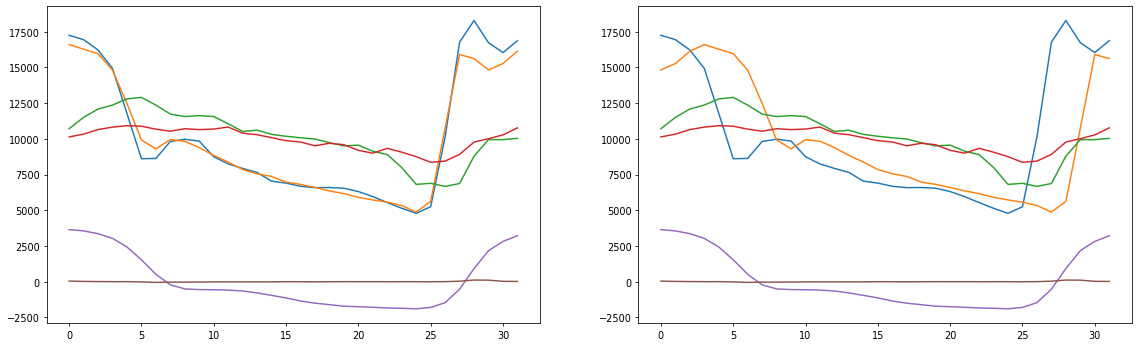

In [11]:
x0 = flows[0].detach().clone()
x, channel_nb = rand_shift(x0)
print(flows[0][channel_nb])
print(x[channel_nb])
plot_side_by_side(flows[0], x)

### ConvNet

In [12]:
print(flows.shape) # All patients
print(flows[0].shape) # 1 patient
print(flows[0][0].shape) # 1 channel

torch.Size([992, 6, 32])
torch.Size([6, 32])
torch.Size([32])


In [48]:
layers = [[32,   6,  8],
          [16,  32,  8],
          [8,  128,  8],
          [1, 6*32,  8]]

model = ConvNet(layers)
print(model)

ConvNet(
  (dropout): Dropout(p=0.0, inplace=False)
  (conv0): Conv1d(6, 32, kernel_size=(8,), stride=(1,), padding=same, padding_mode=circular)
  (pool0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(32, 128, kernel_size=(8,), stride=(1,), padding=same, padding_mode=circular)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 192, kernel_size=(8,), stride=(1,), padding=same, padding_mode=circular)
  (pool2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
)


In [58]:
x0 = flows[0].detach().clone()
x, channel_nb = rand_shift(x0)
y = model(x.unsqueeze_(0)).view([6, 32])
p_shift = torch.softmax(y, dim=1)
print(p_shift)

tensor([[0.0379, 0.0246, 0.0288, 0.0326, 0.0306, 0.0306, 0.0247, 0.0260, 0.0310,
         0.0262, 0.0354, 0.0316, 0.0228, 0.0295, 0.0245, 0.0357, 0.0365, 0.0307,
         0.0335, 0.0350, 0.0324, 0.0347, 0.0188, 0.0473, 0.0339, 0.0261, 0.0312,
         0.0230, 0.0410, 0.0376, 0.0274, 0.0385],
        [0.0375, 0.0287, 0.0297, 0.0328, 0.0307, 0.0221, 0.0341, 0.0507, 0.0211,
         0.0313, 0.0271, 0.0237, 0.0358, 0.0281, 0.0331, 0.0396, 0.0255, 0.0305,
         0.0278, 0.0369, 0.0385, 0.0227, 0.0227, 0.0157, 0.0285, 0.0217, 0.0311,
         0.0259, 0.0376, 0.0393, 0.0476, 0.0420],
        [0.0268, 0.0369, 0.0290, 0.0360, 0.0224, 0.0387, 0.0243, 0.0293, 0.0227,
         0.0350, 0.0445, 0.0372, 0.0420, 0.0253, 0.0299, 0.0355, 0.0401, 0.0236,
         0.0247, 0.0244, 0.0275, 0.0317, 0.0261, 0.0260, 0.0286, 0.0352, 0.0387,
         0.0434, 0.0312, 0.0272, 0.0292, 0.0267],
        [0.0366, 0.0303, 0.0381, 0.0386, 0.0309, 0.0405, 0.0352, 0.0462, 0.0248,
         0.0363, 0.0275, 0.0291, 0.0272,